In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from scipy.stats import mode

from generic_data import GenericDataset
from SimpleNNs import TwoNetBC, FiveNetBC
from model_helper import train_epoch, eval_model, eval_ensemble

In [2]:
Xtrain = np.load("./data/Xtrain.npy")
Ytrain = np.load("./data/Ytrain.npy")
Xtest = np.load("./data/Xtest.npy")
Ytest = np.load("./data/Ytest.npy")

In [3]:
train_dataset = GenericDataset(Xtrain, Ytrain)
test_dataset = GenericDataset(Xtest, Ytest)

In [4]:
# Define model parameters
input_size = 4
output_size = 1
hidden_size = 4
shuffle = True

# Define training parameters
epochs = 200
lr = 0.01
batch_size = 64

# Device parameters
device = "cuda"

# Ensemble parameters
num_models = 50

In [5]:
list_of_models = []
accs = []

In [6]:
for i in range(num_models):
    # Initialize new model
    model=TwoNetBC(input_size, output_size, hidden_size)
    #optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99)
    criterion = nn.BCELoss()
    train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=shuffle)
    model.to(device)
    
    e_losses = []
    
    # Train model
    for epoch in range(epochs):
        loss = train_epoch(model, optimizer, criterion, train_loader, device, batch_size)
        e_losses.append(loss)
        
    # Evaluate model
    test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=shuffle)
    acc, _, _ = eval_model(model, test_loader)
    
    # Add model to list
    list_of_models.append(model)
    accs.append(acc)
    
    print(f"Model {i}: Final Loss ({e_losses[-1]:.6f}), Test Acc ({acc:.4f})")
    

Model 0: Final Loss (0.573354), Test Acc (0.7200)
Model 1: Final Loss (0.545879), Test Acc (0.7175)
Model 2: Final Loss (0.580320), Test Acc (0.7200)
Model 3: Final Loss (0.469355), Test Acc (0.8050)
Model 4: Final Loss (0.568867), Test Acc (0.7150)
Model 5: Final Loss (0.441518), Test Acc (0.8150)
Model 6: Final Loss (0.569504), Test Acc (0.6975)
Model 7: Final Loss (0.436381), Test Acc (0.8325)
Model 8: Final Loss (0.451914), Test Acc (0.8300)
Model 9: Final Loss (0.606642), Test Acc (0.7025)
Model 10: Final Loss (0.466292), Test Acc (0.8200)
Model 11: Final Loss (0.528136), Test Acc (0.7750)
Model 12: Final Loss (0.564231), Test Acc (0.6625)
Model 13: Final Loss (0.515050), Test Acc (0.7500)
Model 14: Final Loss (0.503866), Test Acc (0.7575)
Model 15: Final Loss (0.463722), Test Acc (0.8325)
Model 16: Final Loss (0.435033), Test Acc (0.8375)
Model 17: Final Loss (0.545581), Test Acc (0.6850)
Model 18: Final Loss (0.425297), Test Acc (0.8200)
Model 19: Final Loss (0.490421), Test Acc

In [7]:
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)
ensemble_acc, ensemble_preds, ensemble_labels = eval_ensemble(list_of_models, test_loader)

In [8]:
ensemble_acc

0.87

In [9]:
running_ensemble_acc = []
running_ensemble_acc.append(accs[0])

In [10]:
running_avg_acc = []
running_avg_acc.append(accs[0])

In [11]:
for i in range(1,num_models):
    test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)
    subset_ensemble_acc, _, _ = eval_ensemble(list_of_models[0:i], test_loader)
    running_ensemble_acc.append(subset_ensemble_acc)

In [12]:
for i in range(1, num_models):
    running_avg_acc.append( (running_avg_acc[i-1]*i + accs[i]) / (i+1) )

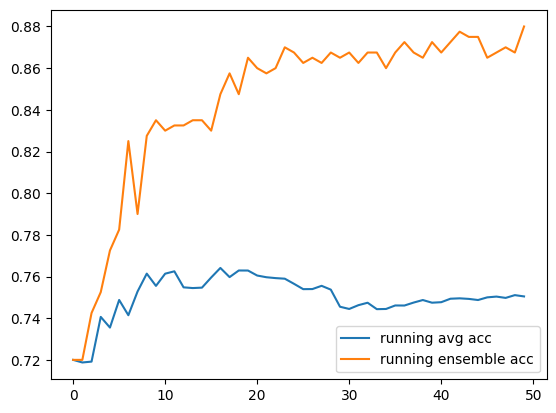

In [13]:
plt.plot(running_avg_acc, label="running avg acc")
plt.plot(running_ensemble_acc, label="running ensemble acc")
plt.legend()